# Aprendizaje Formal

## Práctica 2: Regresión lineal con una variable

### Índice de la práctica
- [Regresión lineal con una variable](#Regresión-lineal-con-una-variable)
- [Solución directa](#Solución-directa)
- [Descenso por gradiente](#Descenso-por-gradiente)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from test_helper import Test
 
%matplotlib inline  

### Regresión lineal con una variable

En primer lugar se debe leer los datos almacenados en el fichero ex1data.txt mediante la función `loadtxt` de NumPy. Los datos contenidos en este fichero corresponden a un problema en el que se debe predecir el beneficio de un camión de comida (food truck) en base al número de habitantes de una ciudad. En este fichero está almacenado el histórico de los camiones de comida de una franquicia. La primera columna corresponde al número de habitantes de una ciudad (en decenas de miles) y la segunda columna corresponde a los beneficios obtenidos con el camión de comida (en decenas de miles).

Mostrar los 5 primeros registros para comprobar que la lectura se haya realizado correctamente.

In [2]:
data = np.loadtxt('ex1data1.txt', delimiter=',')
# Mostrar 5 primeros registros
print(data[:5])

[[ 6.1101 17.592 ]
 [ 5.5277  9.1302]
 [ 8.5186 13.662 ]
 [ 7.0032 11.854 ]
 [ 5.8598  6.8233]]


A continuación debéis crear los datos de entrada ($X$) y de salida ($y$) para poder realizar el aprendizaje de los parámetros de la regresión lineal ($\theta$). Recordad que la primera columna de los datos de entrada debe estar compuesta por unos para multiplicar al término independiente de la regresión lineal. Por tanto, la variable $X$ estará compuesta por dos columnas: una de unos y otra con los datos correspondientes al número de habitantes de las ciudades. La variable $y$ estará compuesta por los beneficios de los camiones de comida en las diferentes ciudades.

In [23]:
# Debéis crear una columna de unos y concaternala con la primera columna de data
# Utiliza la función vstack para concatenar dos vectores y luego toma la traspuesta para lograrlo la X en la forma deseada (sino tendrás que utilizar un reshape antes del hstack)

ones = np.ones(len(data))
X = np.vstack((ones, data[:, 0])).T
# print(X)
# y debe ser un vector columna, es decir una matriz de m x 1. 
# Para ello, debes tomar la segunda columna de data y luego hacer un reshape(-1, 1). El -1 le indica a numpy que debe estimar el tamaño automáticamente

y = data[:, 1].reshape(-1, 1)
#print(y)

Vamos a mostrar una gráfica de puntos para visualizar la distribución de las instancias del problema. De esta forma podemos comprobar si es posible que el modelo de regresión lineal se ajuste bien a los datos o no.

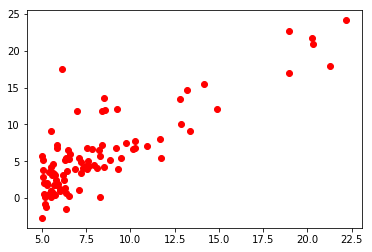

In [4]:
plt.scatter(X[:, 1], y, color = 'red')

#### Solución directa

Como primera aproximación para la regresión vamos a implementar la solución análitica o directa. Recordemos que tenemos que estimar los parámetros $\theta$, que en caso de la regresión con una única variable son $\theta_0$ y $\theta_1$ tal que $y = \theta_0 + \theta_1\cdot x$. Para ello, y como ya tenemos los datos en la matriz $X$ con la primera columna siendo todo unos, simplemente obtenemos los valores de los parámetros aplicando la siguiente ecuación.

$$\theta = (X^T X)^{-1}X^Ty$$

Ten cuidado ya que $X$ es una matriz e $y$ es un vector (matriz de $n \times 1$). Por tanto, los productos que aparecen son entre matrices. Recuerda que en numpy el producto entre matrices se realiza mediante `np.dot()`.

A continuación programa la función `regDirecta` que reciba la matriz con los datos $X$ (asumiendo que su primera columna tendrá unos) y devuelva los valores de los parámetros $\theta$ mediante la solución directa. 

**Nota:** En Python puedes usar la función `np.linalg.pinv` para obtener la inversa de una matriz.

In [5]:
def regDirecta(X, y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y)

Utiliza ahora la función que acabas de implementar para obtener los valores de $\theta$ para los datos disponibles.

**Nota: La instrucción Test.assertEquals coprueba si el resultado que habéis obtenido es correcto. En caso de que no sea correcto os devuelve un mensaje de error.**

In [6]:
theta = regDirecta(X, y)

Test.assertEquals(list(np.round(theta, 4)), [-3.8958, 1.193], 'Valor de theta incorrecto')

1 test passed.


Ahora vamos a mostrar la recta aprendida. 

Para ello debéis crear una array de valores comprendidos entre 5 y 23 con incrementos de 1 en 1 y almacenarlo en la variable xx. 

A continuación evaluar todos estos valores utilizando los valores del modelo aprendidos anteriormente (variable theta) y almacenarlos en la variable yy. Se debe aplicar la ecuación de la recta: $y = \theta_0+\theta_1\cdot x$.

Por último se muestra la recta aprendida en la figura que también incluye los puntos a partir de los que se ha realizado el aprendizaje.

Debes replicar esta figura:
![Ejemplo](img1.png "Ejemplo")

(-5, 30)

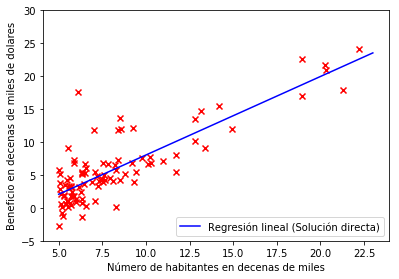

In [7]:
# Crear las variables xx e yy utilizadas para pintar la gráfica posteriormente
xx = np.arange(5, 24)
yy = np.array([theta[0, 0] + theta[1, 0] * x for x in xx])

# Pintar la gráfica

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.scatter(X[:, 1], y, color = 'red', marker = 'x')
axes.plot(xx, yy, 'b', label = "Regresión lineal (Solución directa)")

axes.set_xlabel('Número de habitantes en decenas de miles')
axes.set_ylabel('Beneficio en decenas de miles de dolares')
axes.legend(loc = 4)

axes.set_ylim([-5, 30])

#### Descenso por gradiente

Como ya hemos visto en teoría, el método directo tiene ciertos inconvenientes. En esos casos, el método a utilizar es el descenso por gradiente. Ahora vamos a seguir una serie de pasos para crear nuestro algoritmo de aprendizaje completo.

En primer lugar vamos programar la función de coste para poder aplicar el algoritmo de aprendizaje y que los parámetros de la regresión lineal se ajusten a los datos de tal forma que se minimice dicho coste.

Recordar que la función de coste es: 

$$J(\theta) = \frac{1}{2m}\sum_{i=1}^m \left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right)^2$$

Ten en cuenta que si utilizamos la instrucción `X.dot(theta)` realizamos el producto matricial de los datos de entrada por los parámetros de la regresión. De esta forma lo que logramos es obtener en una única operación la predicción para cada ejemplo de entrada con los paarámetros dados. Es decir, obtenemos predicción del sistema para los datos de entrada: $h_{\theta}\left(x^{(i)}\right)$

In [8]:
def computeCost(X, y, theta):
    m = y.size
    
    # Obtener h (la salida para cada ejemplo) y J a partir de la salida (error)
    h = X.dot(theta)
    s = np.sum(np.square(h[:, 0] - y[: , 0]))
    
    J = (1 / (2 * m)) * s
    return(J)

Vamos a comprobar si la función de coste está bien hecha. Para ello debéis crear los valores iniciales de los parámetros $\theta$ de la regresión lineal como un array columna de ceros (lista de listas de un elemento). Luego, debéis llamar a la función `computeCost` con los datos de entrada ($X$), de salida ($y$) y los parámetros del modelo ($\theta$). Almacenar el resultado en la variable resultado.

Imprimir en pantalla el resultado.

Recuerda que la instrucción `Test.assertEquals` comprueba si el resultado que habéis obtenido es correcto. En caso de que no sea correcto os devuelve un mensaje de error.

In [9]:
# Crear theta como un array de 0's y obtener el error (coste)
theta = np.zeros((2, 1))
resultado = computeCost(X, y, theta)
print("Resultado: ", resultado)

Resultado:  32.072733877455676


In [10]:
# Test para comprobar la corrección
Test.assertEquals(round(resultado, 5), 32.07273, 'Resultado incorrecto')

1 test passed.


A continuación vamos a implementar de la función del descenso por gradiente para realizar el aprendizaje de los parámetros del modelo. Esta función recibe como parámetros de entrada los valores de entrada, de salida, los valores iniciales del modelo, el valor que establece la velocidad de convergencia del algoritmo ($\alpha$) y el número de iteraciones a realizar por el algoritmo.

Como salida devuelve los parámetros aprendidos (variable theta) así como el historial de la evolución de error cometido con cada configuración de valores del modelo (variable J_history). Fijaros que esta última variable almacena el resultado de la función de coste implementada anteriormente para los valores del modelo que han sido actualizados en la instrucción anterior. 

En cada iteración se deben aplicar los siguientes pasos:
1. Calcular la salida del modelo $h_{\theta}(x^{(i)})$ para todo $i\in{1,...,m}$. Recuerda que esto podemos hacerlo en un paso para todos los ejemplos tal y como lo hemos hecho en `computeCost`.
2. Actualizar los valores de $\theta$ aplicando
$$ \theta = \theta - \alpha \cdot \frac{1}{m}  \sum_{i=1}^m(h_{\theta}(x^{(i)}) - y^{(i)}) \cdot x^{(i)} $$
Ten en cuenta que puedes actualizar todos los parámetros de manera simultánea mediante operaciones entre matrices. Tienes los valores de salida $h_{\theta}(x)$ en un vector. Calcula la diferencia con $y$. Ahora si haces la multiplicación matricial entre $X^T$ y el vector diferencia obtendrás el resultado correspondiente al sumatorio. Es decir, la fórmula queda de la siguiente forma.
$$ \theta = \theta - \alpha \cdot \frac{1}{m}  X^T \cdot (h_{\theta}(x) - y) $$
3. Utiliza la función `computeCost` para calcular el coste de los nuevos parámetros y guarda el coste en el array `J_history`.

In [11]:
def gradientDescent(X, y, theta, alpha=0.01, num_iters=1500):
    m = y.size
    J_history = np.zeros(num_iters)
    
    for iter in np.arange(num_iters):
        # Obtener h, recalcula el nuevo theta y alamacenar en J_history[iter] el coste actual
        
        h = X.dot(theta)
        
        difference = h - y
        theta = theta - alpha * (1 / m) * X.T.dot(difference)
        
        J_history[iter] = computeCost(X, y, theta)
        
    return(theta, J_history)

Con el método del gradiente implementado ya podemos realizar el aprendizaje. Para ello debemos llamar a la función `gradientDescent` con los valores de entrada ($X$), los de salida ($y$) y los valores iniciales de los parámetros del modelo ($\theta$), inicializados a cero anteriormente.

A continuación se muestran los parámetros por pantalla y se comprueba si son correctos.

Utiliza después la función plot de matplotlib para mostrar la gráfica de la evolución del error con respecto a las iteraciones del descenso por gradiente (es decir, mostrar los costes obtenidos en cada iteración).

Debes replicar esta figura:
![Ejemplo 2](img2.png "Ejemplo 2")

theta:  [-3.63029144  1.16636235]


(0, 1600)

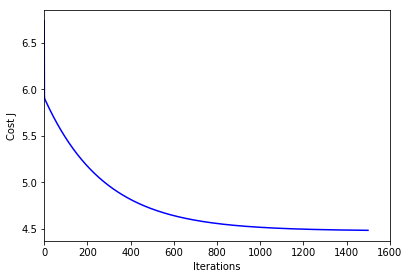

In [12]:
# Comenzamos con theta a 0's y utilizamos la función anterior para optimizar sus valores para obtener el nuevo theta y el historial de J
theta = np.zeros(shape=[2,1])
theta, J_history = gradientDescent(X, y, theta)
print('theta: ', theta.ravel())

# Muestra la gráfica con la evolución del coste J obtenido de la salida de gradientDescent
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot([i for i in np.arange(1500)], J_history, 'b')

axes.set_xlabel('Iterations')
axes.set_ylabel('Cost J')
axes.set_xlim([0, 1600])

In [13]:
# Comprobamos los valores de theta
Test.assertEquals(list(np.round(theta, 5)), [-3.63029,  1.16636], 'Valores de theta incorrectos')

1 test passed.


Al igual que hemos hecho antes con la solución directa vamos a mostrar la recta aprendida.

Reutiliza el código anterior para mostrarla. ¿Observas diferencias? ¿Son muy diferentes los valores de los parámetros?

(-5, 30)

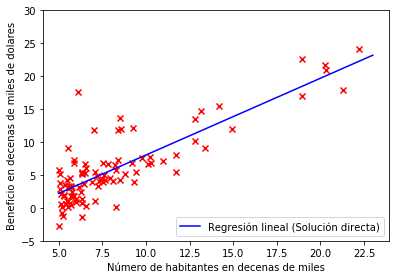

In [14]:
# Crear las variables xx e yy utilizadas para pintar la gráfica posteriormente
xx = np.arange(5, 24)
yy = np.array([theta[0, 0] + theta[1, 0] * x for x in xx])

# Pintar la gráfica

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.scatter(X[:, 1], y, color = 'red', marker = 'x')
axes.plot(xx, yy, 'b', label = "Regresión lineal (Solución directa)")

axes.set_xlabel('Número de habitantes en decenas de miles')
axes.set_ylabel('Beneficio en decenas de miles de dolares')
axes.legend(loc = 4)

axes.set_ylim([-5, 30])

### Scikit-learn
Una vez realizado el proceso de aprendizaje con funciones definidas por nosotros vamos a pasar a usar la librería ofrecida por Python para realizar tareas de aprendizaje automático. Esta librería se llama scikit-learn y se puede visitar en la siguiente URL: http://scikit-learn.org/stable/. En algunos casos la usaremos a lo largo de la asignatura. 

Hoy vamos a comenzar utilizando las funcionalidades relacionadas con la regresión lineal. Podéis consular toda la información en la siguiente URL: http://scikit-learn.org/stable/modules/linear_model.html

* Para ello hay que importar la clase LinearRegression del paquete `linear_model` ofrecido en scikit-learn (la librería se llama sklearn). 
* Una vez importada la clase debemos llamar al constructor para inicializar el modelo de regresión lineal. 
* Después hay que realizar el aprendizaje y para ello se utiliza la función `fit`, a la que se le pasan los datos de entrada ($X$) y las salidas correspondientes ($y$). Esta función automáticamente realiza el aprendizaje y modifica internamente los parámetros del modelo (`intercept_` y `coef_` para el término independiente y los $\theta$ asociados a cada variable del problema, respectivamente).
* Para clasificar nuevos datos tenemos dos opciones
    * Utilizar `intercept_` y `coef_` aplicando la ecuación de la regresión lineal: $ y = intercept\_ + coef\_ \cdot x $
    * Utilizar la función `predict`, a la que se le pasa los datos de entrada de las instancias a predecir y devuelve las predicciones.

En el código mostrado a continuación se ve un ejemplo del uso de esta librería con comentarios sobre qué se realiza en cada instrucción de código. Finalmente se muestra en una gráfica tanto la recta aprendida anteriormente como la recta aprendida con la librería scikit-learn.

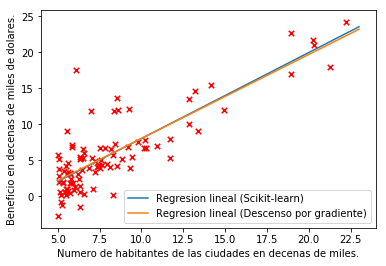

In [15]:
# Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión lineal
from sklearn.linear_model import LinearRegression

# Se incializa el modelo llamando al constructor de la regresión lineal: todos los parámetros se asignan a sus valores por defecto
regr = LinearRegression()
# Se entrena el modelo (aprendizaje) utilizando la variable de entrada sin los unos X[:,1] y la variable de salida (y)
# La función ravel devuelve una lista (si la entrada es una lista de listas coge todos los elementos y los almacena en la lista devuelta)
# En la función reshape el valor -1 significa que el tamaño de esa dimensión se calcula automáticamente en base a la otra
    # En este caso hacemos una columna de tantas filas como instancias tengan los datos
regr.fit(X[:,1].reshape(-1,1), y.ravel())
# Se evalúan los valores creados anteriormente para comparar ambos modelos aprendidos
prediccionesOpcion1 = regr.intercept_+regr.coef_*xx
prediccionesOpcion2 = regr.predict(xx.reshape(-1,1))
plt.plot(xx, prediccionesOpcion2, label='Regresion lineal (Scikit-learn)')
# Se muestra los datos a partir de los cuales se ha aprendido
plt.scatter(X[:,1], y, s=30, c='r', marker='x', linewidths=1)
# Se muestra la recta aprendida anteriormente para comparar
plt.plot(xx,yy, label='Regresion lineal (Descenso por gradiente)')

plt.xlim(4,24)
plt.xlabel('Numero de habitantes de las ciudades en decenas de miles.')
plt.ylabel('Beneficio en decenas de miles de dolares.');
plt.legend(loc=4);

#### Predicción de nuevos datos

Una vez aprendido el modelo de regresión lineal podemos utilizarlo para predecir datos que no han sido utilizados durante el entrenamiento. En este caso debéis predecir el valor de dos ciudades: la primera tiene 35.000 habitantes y la segunda 70.000 habitantes. Recordar que tanto el número de habitantes como el beneficio con el que se ha aprendido el modelo de regresión lineal está expresado en decenas de miles de habitantes.

Predecir los beneficios de ambas ciudades utilizando los valores de los parámetros aprendidos por las funciones definidas por nosotros.


In [16]:
# Predecir el beneficio para dos ciudades (ciudad1 y ciudad2) de 35000 y 70000 habitantes, respectivamente
ciudad1 = (theta[0, 0] + theta[1, 0] * (35000 / 10**4)) * 10**4
print(ciudad1)
ciudad2 = (theta[0, 0] + theta[1, 0] * (70000 / 10**4)) * 10**4
print(ciudad2)

4519.7678677017675
45342.45012944714


In [17]:
Test.assertEquals(np.round(ciudad1, 5), 4519.76787, 'Valor de la ciudad 1 incorrecto')
Test.assertEquals(np.round(ciudad2, 5), 45342.45013, 'Valor de la ciudad 2 incorrecto')

1 test passed.
1 test passed.


Finalmente, aquí tienes un código que se utiliza para visualizar el comportamiento de la función de coste ($J$) en función de los parámetros del modelo ($\theta_1$ y $\theta_2$). Se crear dos gráficas, una para mostrar el comportamiento de la función de error en 3 dimensiones y la otra es una gráfica de contornos en la que se observa el nivel de error en cada punto.

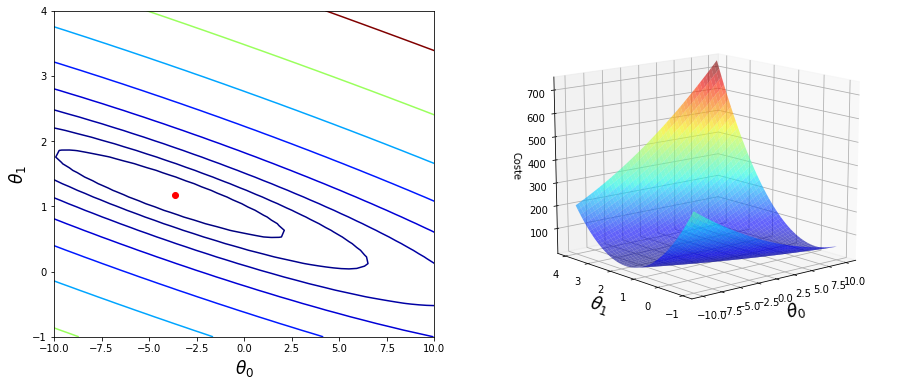

In [18]:
# Se crean 50 puntos en cada dimensión: en el rango [-10, 10] para la población y [-1, 4] para los beneficios
B0 = np.linspace(-10, 10, 50)
B1 = np.linspace(-1, 4, 50)
# Se crean todas las combinaciones de valores de los puntos creados anteriormente
xx, yy = np.meshgrid(B0, B1, indexing='xy')
# Se crea una matriz donde vamos a almacenar el coste de la predicción (error) para cada combinación
Z = np.zeros((B0.size,B1.size))

# Se calcula el error de cada combinación
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] = computeCost(X,y, theta=[[xx[i,j]], [yy[i,j]]])

# Se crea una figura con dos plots: uno para cada tipo de gráfico
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Gráfica de la izquierda: contornos (nivel de error)
CS = ax1.contour(xx, yy, Z, np.logspace(-2, 3, 20), cmap=plt.cm.jet)
ax1.scatter(theta[0],theta[1], c='r')

# Gráfica de la izquierda: comportamiento de la función de coste
ax2.plot_surface(xx, yy, Z, rstride=1, cstride=1, alpha=0.6, cmap=plt.cm.jet)
ax2.set_zlabel('Coste')
ax2.set_zlim(Z.min(),Z.max())
ax2.view_init(elev=15, azim=230)

# Se asignan las etiquetas de los ejes de las dos gráficas
for ax in fig.axes:
    ax.set_xlabel(r'$\theta_0$', fontsize=17)
    ax.set_ylabel(r'$\theta_1$', fontsize=17)

### Tarea extra
Modifica la función `gradientDescent` para que devuelva una matriz (o lista) con los valores de $\theta$ de cada iteración. Ahora utiliza estos valores para mostrar los puntos por los que ha ido pasando el descenso por gradiente en una gráfica de contornos igual a la que acabas de dibujar (la de la izquierda).

Debes replicar esta figura:
![Ejemplo 3](img3.png "Ejemplo 3")

theta:  [-3.63029144  1.16636235]


Text(0,0.5,'$\\theta_1$')

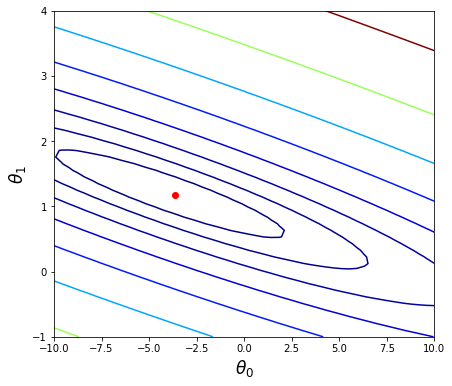

In [21]:
def gradientDescent(X, y, theta, alpha=0.01, num_iters=1500):    
    m = y.size
    J_history = np.zeros(num_iters)
    thetas = np.zeros((num_iters, theta.size))
    
    for iter in np.arange(num_iters):
        h = X.dot(theta)
        
        difference = h - y
        theta = theta - alpha * (1 / m) * X.T.dot(difference)
        
        J_history[iter] = computeCost(X, y, theta)
        thetas[iter] = theta.reshape(1, 2)
        
    return(theta, J_history, thetas)

# theta para minimizar la función de coste J
# Obtener theta, el historial del coste y el de los thetas (llamado thetas)
# Inicializamos theta a 0's
theta = np.zeros(shape=[2,1])
theta, J_history, thetas = gradientDescent(X, y, theta)
print('theta: ', theta.ravel())


# Pintar la gráfica de contornos con cada uno de los puntos por los que ha pasado el descenso por gradiente

# Se crean 50 puntos en cada dimensión: en el rango [-10, 10] para la población y [-1, 4] para los beneficios
B0 = np.linspace(-10, 10, 50)
B1 = np.linspace(-1, 4, 50)
# Se crean todas las combinaciones de valores de los puntos creados anteriormente
xx, yy = np.meshgrid(B0, B1, indexing='xy')
# Se crea una matriz donde vamos a almacenar el coste de la predicción (error) para cada combinación
Z = np.zeros((B0.size,B1.size))

# Se calcula el error de cada combinación
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] = computeCost(X,y, theta=[[xx[i,j]], [yy[i,j]]])

# Se crea una figura 
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)

# Gráfica de la izquierda: contornos (nivel de error)
CS = ax1.contour(xx, yy, Z, np.logspace(-2, 3, 20), cmap=plt.cm.jet)
ax1.scatter(theta[0],theta[1], c='r')


# Se asignan las etiquetas de los ejes de las dos gráficas
ax1.set_xlabel(r'$\theta_0$', fontsize=17)
ax1.set_ylabel(r'$\theta_1$', fontsize=17)


In [20]:
Test.assertEquals(list(np.round(theta, 5)), [-3.63029,  1.16636], 'Valores de theta incorrectos')
Test.assertEquals(list(np.round(thetas[25:30], 5).ravel()), [-0.10245, 0.81195, -0.10929, 0.81264, -0.11612, 0.81333, -0.12293, 0.81401, -0.12973, 0.81469], 'Valores del historial de thetas incorrectos')

1 test passed.
1 test passed.
